# ST449 - Artificial Intelligence and Deep Learning

# Assignment 1 - Lent Term 2020-2021

---

## Instructions:

**Deadline**: February 26th, 2021, 7pm London time.


## P1. MNIST classification using multi-class logistic regression 

Consider a L2-regularized multi-class logistic regression model using the MNIST dataset. 

The model is given by
$\hat{y}=\sigma(W^TX+\mathbf{b})$, where $\sigma(\cdot)$ is 
the softmax function 
$$\sigma_j(x) = \frac{e^{z_j}}{\sum_{k=1}^{K}e^{z_k}}$$

The objective is the cross-entropy loss function:

$$l(\hat{y},y)=-\sum_{k=1}^{K}y_k\log(\hat{y_k})$$

where $K$ is the number of classes and $\hat{y_{k}}$ is the output probability that a sample belongs to class k, with a L2 regularizer on the weight parameters $W$, i.e., $\lambda||W||_2^2$, the L2 norm of the vectorized $W$ where $\lambda$ is a hyper-parameter. 

The hyper-parameter settings are given as below:
- minibatch size = 128 
- starting learning rate $\eta^{(0)}=0.001$
- decaying learning rate $\eta^{(t)}=\eta^{(0)}/\sqrt{t}$ during training where $t$ is the number of epochs 
- Momentum = 0.7
- $\lambda=0.01$
- total number of epoches = 45

**Task:** Evaluate and plot **the average loss per epoch** versus the number of epochs for the training dataset, for the following optimization algorithms:
- Mini-batch gradient descent
- Mini-batch AdaGrad
- Mini-batch gradient descent with Nesterov’s momentum
- Mini-batch Adam 

Discuss how the performance of different optimization algorithms compare to each other.


***
#### Intial comments
Firstly, to monitor the learning process, I use _tensorboard_ and include screenshots where appropriate. For replication purposes, I also included the log directory in this repository. To serve tensorboard on port http://localhost:6006, run `tensorboard --logdir=path_to_your_logs`.

Secondly, I apply the learning rate decay only to the two stochastic gradient descent (SGD) optimizers (in addition to the momentum or Nesterov momentum). The instructions above seem to suggest that it should be applied to all optimizers. However, I do not use the decay in combination with methods that naturally lead to adaptive gradients (such as AdaGrad and Adam) in order to not obscure this effect.

In [3]:
# tensorflow 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

# other libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from IPython.display import Image

#### Load the Data

In [2]:
# from the Keras documentation
# model and data parameters
num_classes = 10
input_shape = (28, 28)

# split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


#### Logistic Regression Model

In [3]:
# build the model
def get_model(name=None):
    model = keras.Sequential(name=name)
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax', kernel_regularizer='l2')) # l2 penalty defaults to 0.01
    return model

# show the general model architecture
get_model('LogReg').summary()

Model: "LogReg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


#### Common Parematers

In [4]:
### COMMON FOR ALL MODELS IN PART 1
# specify loss function
loss = keras.losses.CategoricalCrossentropy()

# initial learning rate
initial_learning_rate = 0.001

# tensorboard callback
log_dir = "./logs/p1/"

# training parameters
batch_size = 128
epochs = 45

### 1.1. Stochastic Gradient Descent with Momentum and Weight Decay

In [5]:
# build the model
name = 'SGD'
model = get_model(name)

# specify optimizer
optimizer = keras.optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.7)

# compile the model
model.compile(optimizer, loss, metrics=["accuracy"])

# learning rate decay using a Keras callback
def scheduler(epoch, lr):
    return initial_learning_rate / (epoch+1)**0.5

lr_callback = keras.callbacks.LearningRateScheduler(scheduler)

# tensorboard callback
tb_callback = TensorBoard(log_dir=log_dir+name)

# fit the model
historySGD = model.fit(x_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_data=(x_test, y_test),
                       callbacks=[lr_callback, tb_callback],
                       verbose=False)

# evaluate the loss and accuracy on test set
SGD = model.evaluate(x_test, y_test, return_dict=True, verbose=0)

### 1.2. Adaptive Gradient Algorithm (AdaGrad)

In [6]:
# build the model (to reset the weights)
name = 'AdaGrad'
model = get_model(name)

# new optimizer
optimizer = keras.optimizers.Adagrad(learning_rate=initial_learning_rate)

# tensorboard callback
tb_callback = TensorBoard(log_dir=log_dir+name)

# compile and fit the model
model.compile(optimizer, loss, metrics=["accuracy"])
historyAda = model.fit(x_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_data=(x_test, y_test),
                       callbacks=[tb_callback],
                       verbose=False)

AdaGrad = model.evaluate(x_test, y_test, return_dict=True, verbose=0)

### 1.3. Stochastic Gradient Descent with Nesterov Momentum and Weight Decay

In [7]:
# build the model
name = 'Nesterov'
model = get_model(name)

# new optimizer
optimizer = keras.optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.7, nesterov=True)

# tensorboard callback
tb_callback = TensorBoard(log_dir=log_dir+name)

# compile and fit the model
model.compile(optimizer, loss, metrics=["accuracy"])
historyNes = model.fit(x_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_data=(x_test, y_test),
                       callbacks=[lr_callback, tb_callback],
                       verbose=False)

Nesterov = model.evaluate(x_test, y_test, return_dict=True, verbose=0)

### 1.4. Adaptive Moment Estimation (Adam)

In [8]:
# build the model
name = 'Adam'
model = get_model(name)

# new optimizer
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

# tensorboard callback
tb_callback = TensorBoard(log_dir=log_dir+name)

# compile and fit the model
model.compile(optimizer, loss, metrics=["accuracy"])
historyAdam = model.fit(x_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_data=(x_test, y_test),
                       callbacks=[tb_callback],
                       verbose=False)

Adam = model.evaluate(x_test, y_test, return_dict=True, verbose=0)

### 1.5. Discussion of the Results

In [9]:
models = [VGD, AdaGrad, Nesterov, Adam]
df = pd.DataFrame(models, index=['VGD', 'AdaGrad', 'Nesterov', 'Adam'])
print('Test Loss and Accuracy:')
df

Test Loss and Accuracy:


,loss,accuracy
VGD,0.764967,0.8791
AdaGrad,0.726300,0.8833
Nesterov,0.762767,0.8802
Adam,0.644302,0.8983


#### Training Loss

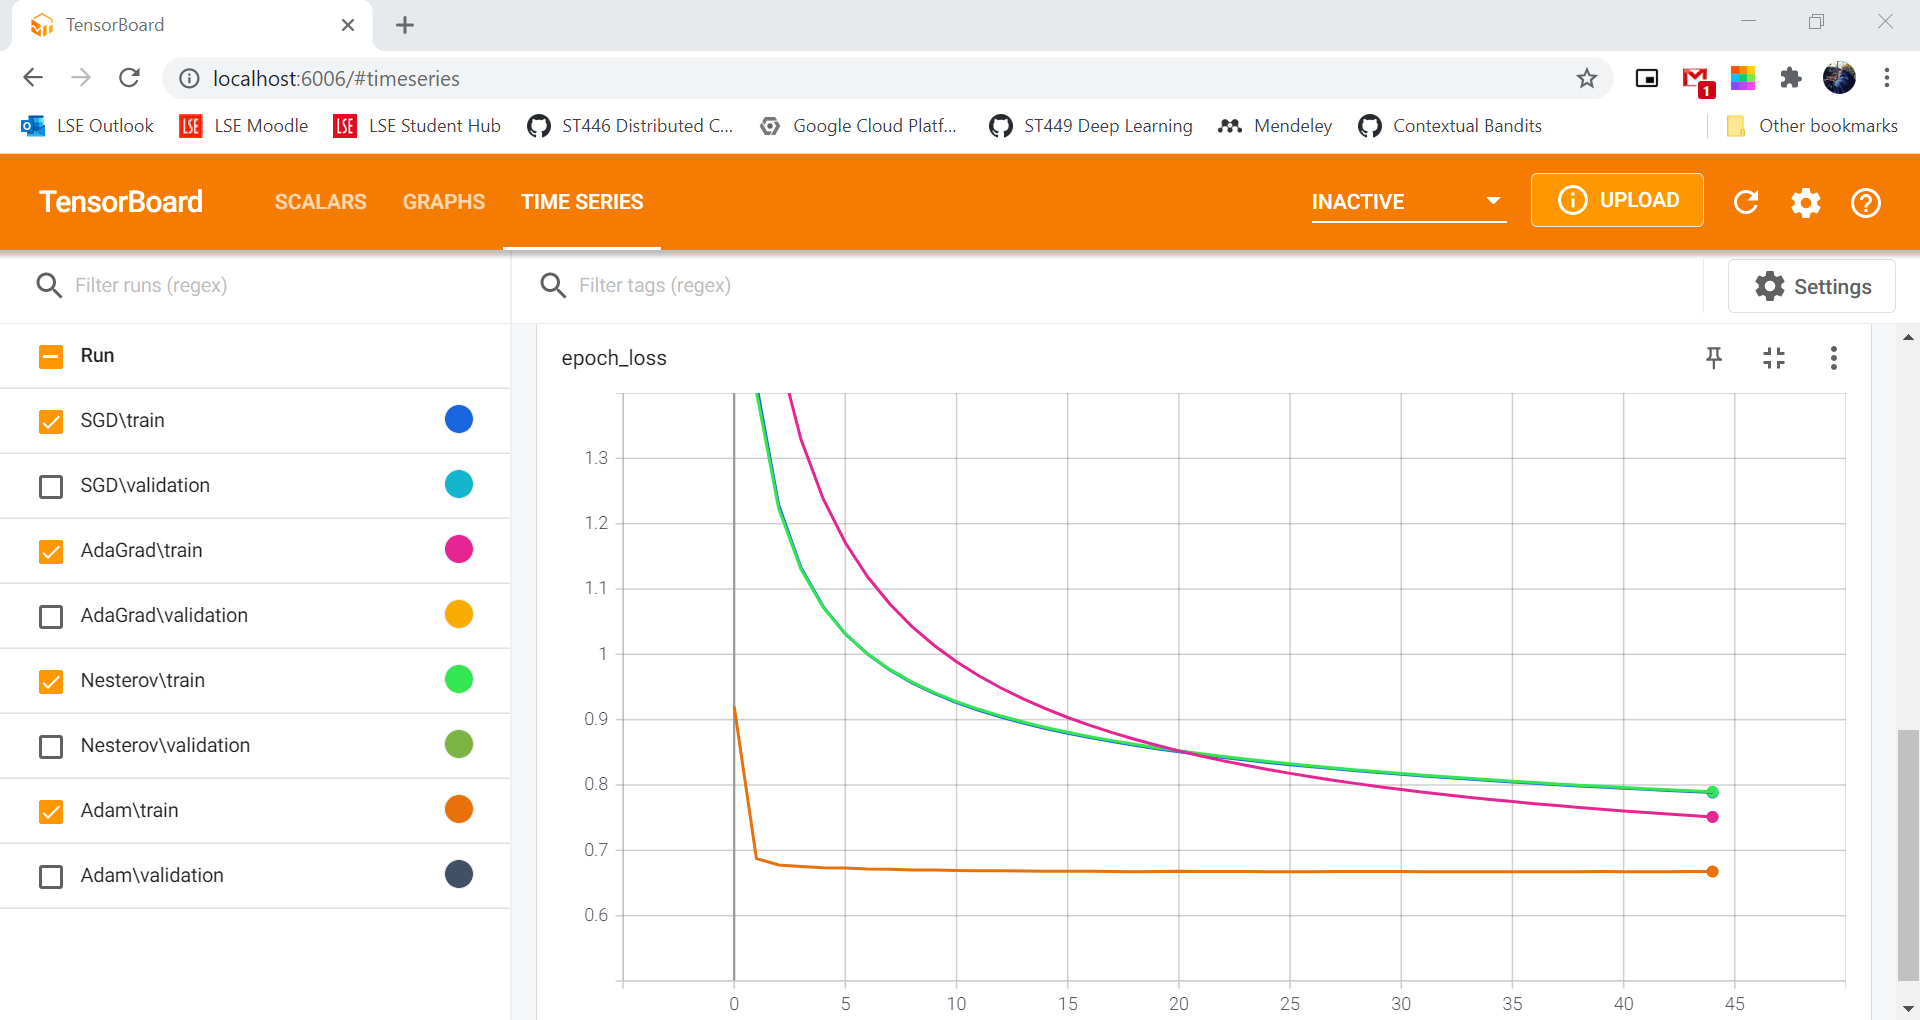

In [3]:
Image(filename='images/p1_train_loss.PNG')

To begin with, there is little difference between the **Stochastic Gradient Descent** with standard momentum versus Nesterov momentum. The two loss curves are essentially equivalent. This is not surprising given that their momentum is defined in a very similar way. As compared to **AdaGrad**, SGD initially learns much faster. That is, it achieves a relatively low loss more quickly, which is most likely the result of the momentum (_most likely_ because the adaptive nature of AdaGrad can also lead to larger gradients in some cases (especially for sparse updates), so the effect can be generally similar). However, the loss curves of the two SGD models slowly level off while AdaGrad continues to improve during later epochs. An explanation for this is that the SGD models use a fixed learning rate decay while the AdaGrad model, as its name suggests, is able to adapt its gradients without the need for an explicit learning rate schedule. As a result, after 45 epochs, AdaGrad achieves a lower training error than SGD with momentum and weight decay.

**Adam** stands out as the fastest learner here. It combines the ideas of an adaptive learning rate with momentum, which makes it a very effective and popular optimizer in many deep learning domains. It is also quite robust with respect to its hyperparameter specifications. As can be seen above, Adam reaches its minimum loss very quickly but stagnates afterwards. Despite that, it still has the lowest loss after 45 epochs. On the downside, however, Adam is still somewhat poorly understood and is known to generalize worse than other optimizers (Reference: Nitish Shirish Keskar and Richard Socher (2017): _Improving Generalization Performance by Switching from Adam to SGD_).

#### Validation Loss

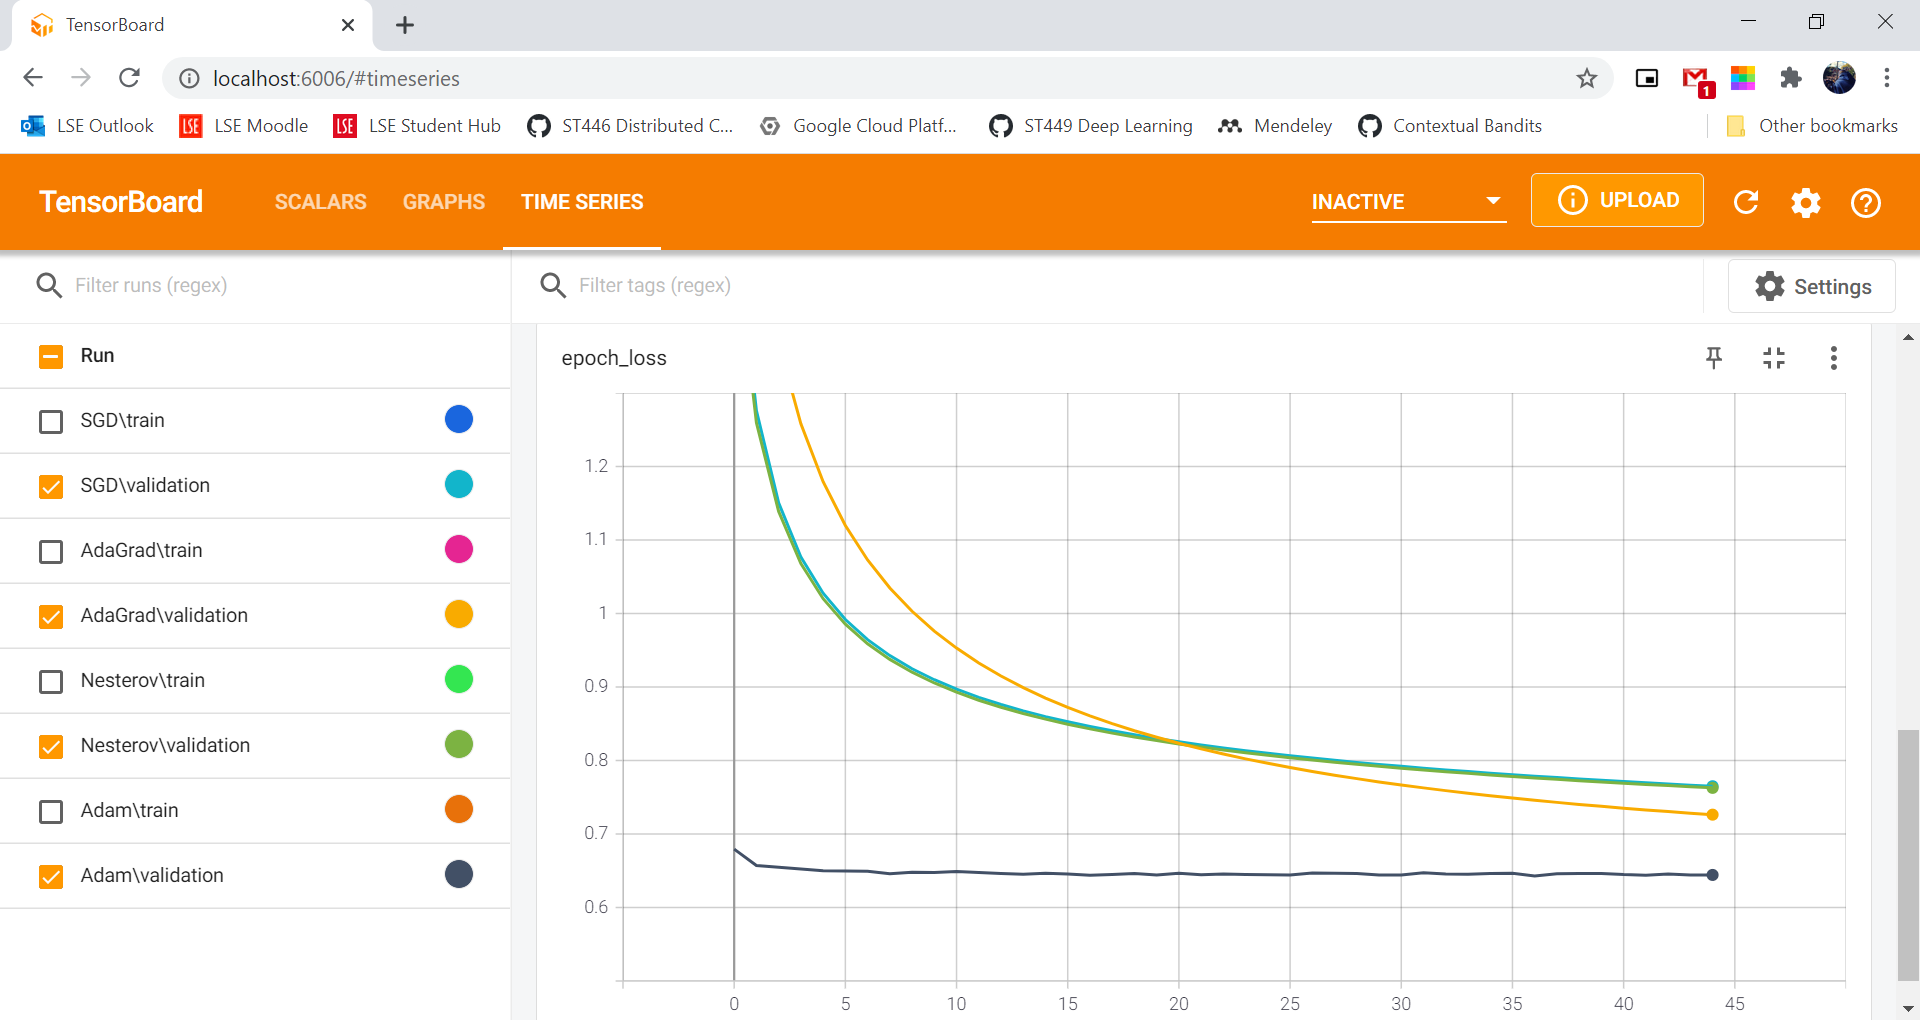

In [4]:
Image(filename='images/p1_val_loss.PNG') 

A look at the validation loss curves (see above) reveals that no method appears to suffer from notable overfitting. That is, the losses decrease as intended but do not start to increase as the learning continues. This may be due to the fact that the number of epochs is only moderate. In fact, three of the four models are still improving their validation loss after 45 epochs of training (except Adam). Additionally, logistic regression is only a simple method that results in a linear decision boundary, which is generally not as prone to overfitting as deep, highly non-linear neural networks.

One interesting observation is that in all four cases, the validation loss is lower than the training loss (a separate plot for each model is in the images folder, the effect can be seen more clearly there). This can be a sign of strong regularization. In other words, if the network is prevented from fitting to the training data too much, it sometimes fits the evaluation data more closely; especially if the regularization is "turned off" during evaluation as opposed to training (as is the case with dropout).

However, in this case, a more likely explanation is the following: the training loss is an average over all batches in each epoch while the evaluation loss is evaluated at the end of each epoch. In other words, earlier batches during an epoch of training can cause the average training loss to be higher than the evaluation loss, which is evaluated using a later, more improved model.

## P2. CIFAR10 CNN: convergence of minibatch gradient descent

Implement a CNN architecture that consists of 3 convolutional layers followed by a hidden fully connected layer of 1000 units. 

Each convolutional layer consists of a sublayer of 5x5 convolutional filters with stride 1 followed by a sublayer of 2x2 max-pool units with stride 2. Each neuron applies ReLU activation function.

**Task:** Evaluate **both the training and test loss function values** versus the number of epochs. In addition, show the results by adding dropout. Comment the results. 

**Hints:**

- Load CIFAR10 data by the following code:
```
from keras.datasets import cifar10
(data_train, label_train), (data_test, label_test) = cifar10.load_data()
```
- In order to reduce the training time, use only the first 50 mini-batches for each epoch. 
- More specifically, at the beginning of each epoch, randomly shuffle the whole dataset training dataset. Then, only iterate through the first 50 mini-batches for one epoch training.  
- Training on Google Colab GPU is highly recommended. The training time on 1 GPU is roughly 1 minute per epoch.  

The hyper-parameter settings:
- minibatch size = 128 
- learning rate = 0.001
- total number of epoches = 100

#### Load the Data

In [67]:
# model parameters
num_classes = 10
input_shape = (32, 32, 3)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#### Setting some Hyperparameters

In [68]:
# training parameters
batch_size = 128
epochs = 100
learning_rate = 0.001

# tensorboard callback
log_dir = "./logs/p2/"

### 2.1 Without Dropout

#### Model Architecture
I create the model using Keras' functional API, which is the recommended approach for more sophisticated neural network. A simple Sequential model would work here too, but it is generally quite limited. The model subclass API, on the other hand, is mostly used only for custom layers or if the training steps need to be customized. Most often, the functional API is preferred.

In [69]:
name = 'NoDropoutCNN'

# build the model using Keras' functional API
inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(64, kernel_size=5, padding='same', activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(64, kernel_size=5, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Conv2D(128, kernel_size=5, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs, name=name)
model.summary()

Model: "NoDropoutCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 16, 16, 64)        102464    
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 4, 4, 128)        

#### Model Training

In [70]:
# tensorboard callback
tb_callback = TensorBoard(log_dir=log_dir+name)

# specify loss function and optimizer
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate)

# compile the model
model.compile(optimizer, loss, metrics=["accuracy"])

# fit the model
historyNoDrop = model.fit(x_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_data=(x_test, y_test),
                       callbacks=[tb_callback],
                       steps_per_epoch=50,
                       shuffle=True,
                       verbose=False)

### 2.2 With Dropout
#### Model Architecture

In [73]:
name = 'DropoutCNN'

# build the model using Keras' functional API
inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(64, kernel_size=5, padding='same', activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(64, kernel_size=5, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=5, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs, name=name)
model.summary()

Model: "DropoutCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 16, 16, 64)        102464    
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 64)          0

#### Model Training

In [80]:
# tensorboard callback
tb_callback = TensorBoard(log_dir=log_dir+name)

# specify loss function and optimizer
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate)

# compile the model
model.compile(optimizer, loss, metrics=["accuracy"])

# fit the model
historyDrop = model.fit(x_train, y_train, 
                       batch_size=batch_size, 
                       epochs=epochs, 
                       validation_split=0.1,
                       callbacks=[tb_callback],
                       steps_per_epoch=50,
                       shuffle=True,
                       verbose=False)

### 2.3 Discussion of the Results

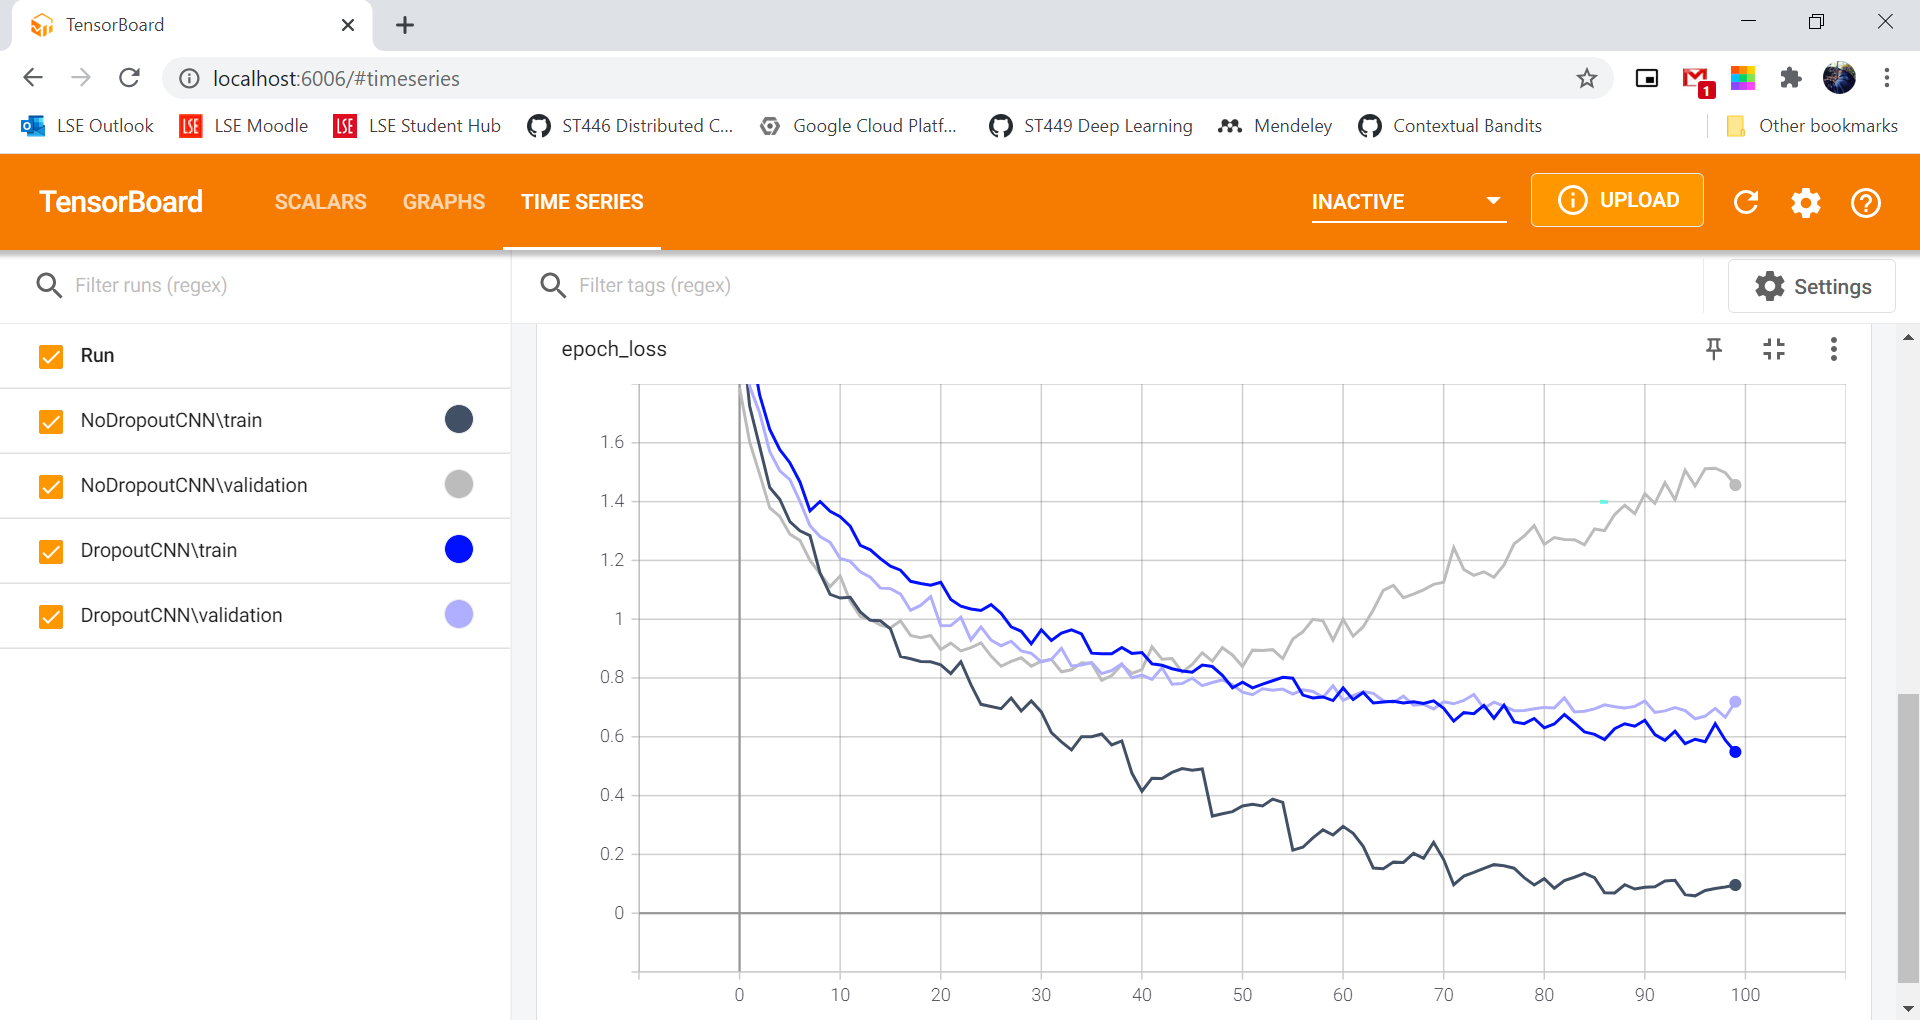

In [4]:
Image(filename='images/p2_loss.PNG')

There are several findings to take away from here. First, let us look at the **model without dropout** (grey curves). Even though the training loss is not strictly decreasing (this is due to the mini-batch gradient descent), it is overall decreasing throughout the 100 epochs. In fact, the loss reaches almost zero. This is proof of the immense expressiveness (=flexibility) of the model, or neural networks more generally. A loss so close to zero even suggests that the network appears to have learned an (almost) deterministic mapping from each training sample to its class. This is usually not what we want. We would rather have the network learn useful feature representations that generalize beyond the training set.

In other words, the no-dropout network appears to strongly overfit the training data. Indeed, we can see that even more clearly when looking at the validation loss curve, which initially drops as expected, but starts to rise after 40 epochs (the loss follows a U shape). This is typical for (deep) neural networks as they are usually over-parameterized (they are more expressive than necessary) and start to overfit at some point during training. The solution to this problem is regularization, which helps the over-parameterized network to find a better fit.

Indeed, dropout is one very common approach to regularization in neural networks (it has some other benefits too, such as a Bayesian interpretation). In short, the random dropping of neurons during training prevents the model from overfitting. Of course, the training loss of the **dropout model** (blue curves) is higher compared to the no-dropout model (the dropout model's expressive power is lower during training). However, the validation loss shows that overfitting does not occur any more. Rather, it follows the training loss downwards, beyond epoch 40 and through to epoch 100 (it is not U shaped any more). In addition, the relatively small gap between the training and validation loss is also a good sign. It shows that the model generalizes well. That is, the weights learned do not only help to classify the training images but also the unseen test images.

The plot is also great depiction of the **bias-variance tradeoff** in deep learning. Having an enormously expressive neural network is generally advantageous because it allows the model to approximate even very complex functions with a low bias (such as a function from pixels to labels). At the same time however, the variance can become huge as the network overfits to the data. Like in other domains of machine learning, regularization can help to find a good bias-variance tradeoff such that overall, the regularized model outperforms the unregularized one on test data.

It is also worth taking a brief look at the dropout layers here. I applied dropout to the convolutional layers as well as the dense layers. However, it is somewhat questionable to what extent dropouts on convolutions are necessary or helpful. Convolutions are sparse by design, so the dropout is not as effective there. Indeed, of the network's approx. 2.4 Mio parameters, more than 2 Mio are in the final two dense layers, which implies that this is where most of the dropout regularization effect occurs.

## P3. CIFAR10 image classification

Design and implement a convolutional neural network for the CIFAR10 image classification task aiming to achieve a high test accuracy. Evaluate the classification accuracy by reporting top-1 and top-5 test error rates. 

**Task:** Plot the loss function, top-1 error rate and top-5 error rate per epoch versus the number of epochs for the training and the test dataset. 
Make sure to well describe and justify your network architecture design choices. 

### 3.1 Model Architecture
Starting from the basic architecture used in the previous part, I try to improve the performance of the network by going deeper (more layers) as well as applying various common deep learning tweaks.

The model consists of four identical blocks of layers, differing only in the number of convolutional filters applied (and in their dimensions, of course - as the number of channels goes up, the other dimensions scale down). Each of the four blocks consists of the following layers:
- 2D convolutions
- batch normalization
- 2D convolutions
- batch normalization
- 2D max pooling

In addition, a dropout layer with probability equal to 0.2 is applied to the first convolutional layer in blocks 2, 3, and 4. The final layer (output layer) of the neural network is a dense layers with 10 neurons.

In [12]:
name='MyCNN'

model = keras.Sequential([
    
    # block 1, 48 channels (filters)
    layers.Conv2D(48, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(1e-4), input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv2D(48, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    
    # block 2, 64 channels
    layers.Dropout(0.2),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    
    # block 3, 128 channels
    layers.Dropout(0.2),
    layers.Conv2D(128, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    
    # block 4, 256 channels
    layers.Dropout(0.2),
    layers.Conv2D(256, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Conv2D(256, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    
    # head of the network
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax'),
])
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 48)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 48)        20784     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        2

#### Some further Comments about the Model Architecture

In all convolutional layers, I use a small kernel size of 3x3 rather than 5x5 or even larger because they have fewer parameters to learn (at the cost of smaller receptive fields). Overall, the model has some 1.2 Mio parameters, which is only have as many as the model in part 2.

Since neural networks are notoriously prone to overfitting, both *weight decay* (in form of l2 regularization) and *dropout* are used to avoid that and improve generalization. The weight decay is applied to all convolutions while the dropout is applied between the blocks (as mentioned) as well as to the final dense layer.

Before each convolution, _batch normalization_, which like weight decay and dropout acts as a regularizer, is applied. It has also has the advantage of reducing the internal covariate shift and ensures that the inputs to the neurons stay close to zero, which reduces the gradient's dependence on the scale of the parameters.

Instead of the Rectified Linear Unit (ReLU) activation function, I use the _Exponential Linear Unit_ (ELU). At the cost of a somewhat higher computational effort, ELU avoids the "dead ReLU" problem, which refers to the fact that many neurons in a network are 0 due to the nature of the ReLU activation. While this can be a good property (a sparse network means faster computations), it also implies that some neurons never learn (i.e., they are "dead"). The ELU activation function can be seen below; it is equivalent to ReLU for $x\ge0$, but still carries some information (and thus gradients) for $x<0$.

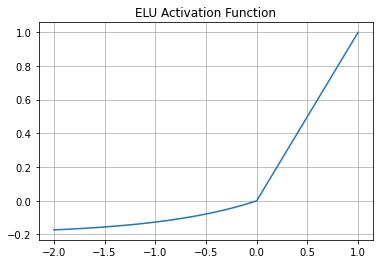

In [ ]:
x = np.linspace(start=-2, stop=1, num=100)
y = tf.keras.activations.elu(x, alpha=0.2).numpy()
plt.plot(x,y)
plt.grid()
plt.title('ELU Activation Function');

### 3.2 Data Augmentation

Another common approach in computer vision is to use data augmentation, which involves creating additional trainings samples from the existing data set. For example, by randomly tilting, shifting, or cropping images, we can essentially generate additional images for training.

There are various reason why data augmentation works. 
- it effectively increases the number of training samples
- it helps avoid overfitting: the model cannot memorize any patterns perfectly as they change from epoch to epoch
- it improves generalization of the model: the test data may be slightly different from the training data in ways that are covered by the random transformations

The three points are certainly interrelated rather than independently true.

In Keras, it is possible to create a pipeline that applies such random transformations to images as they are streamed into the model during training, using the `ImageDataGenerator`. While many different transformations are possible, I stick to the following three basic ones:
1. randomly tilt image by +/- 10 degrees
2. randomly shift image vertically by 10 percent
3. randomly shift image horizontally by 10 percent

In [ ]:
# image augmentation, see https://keras.io/api/preprocessing/image/
datagenerator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

datagenerator.fit(x_train)

### 3.3 Model Training

The final choice is about the optimizer. I use the _Adaptive Moment Estimation_ (Adam) optimizer, which is the one of the most frequently used optimizers in the field of computer vision due its nice properties (adaptive learning rate and momentum, robust with respect to its hyperparameters). I set the learning rate to 0.001.

Like in the previous part, the batch size is set to 128 and the number of epochs to 100.

In [ ]:
# training parameters
batch_size = 128
epochs = 100
learning_rate = 0.001

# specify loss function and optimizer
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate)

# tensorboard callback
log_dir = "./logs/p3/"
tb_callback = TensorBoard(log_dir=log_dir+name)

# compile the model
model.compile(optimizer, loss, metrics=["accuracy", "top_k_categorical_accuracy"]) # top k defaults to k=5

# fit the model with data augmentation
historyMyCNN = model.fit(datagenerator.flow(x_train, y_train, batch_size=batch_size), 
                         epochs=epochs,
                         validation_data=(x_test, y_test),
                         callbacks=[tb_callback])

Epoch 1/100
391/391 [==============================] - 34s 66ms/step - loss: 2.4042 - accuracy: 0.3352 - top_k_categorical_accuracy: 0.8428 - val_loss: 1.3085 - val_accuracy: 0.5879 - val_top_k_categorical_accuracy: 0.9536
Epoch 2/100
391/391 [==============================] - 25s 65ms/step - loss: 1.4029 - accuracy: 0.5485 - top_k_categorical_accuracy: 0.9459 - val_loss: 1.1156 - val_accuracy: 0.6430 - val_top_k_categorical_accuracy: 0.9718
Epoch 3/100
391/391 [==============================] - 26s 66ms/step - loss: 1.1279 - accuracy: 0.6400 - top_k_categorical_accuracy: 0.9678 - val_loss: 1.0185 - val_accuracy: 0.6860 - val_top_k_categorical_accuracy: 0.9760
Epoch 4/100
391/391 [==============================] - 26s 66ms/step - loss: 1.0046 - accuracy: 0.6870 - top_k_categorical_accuracy: 0.9744 - val_loss: 0.9152 - val_accuracy: 0.7349 - val_top_k_categorical_accuracy: 0.9776
Epoch 5/100
391/391 [==============================] - 26s 67ms/step - loss: 0.9239 - accuracy: 0.7149 - top

### 3.4 Discussion of the Results
#### Top-1 Accuracy

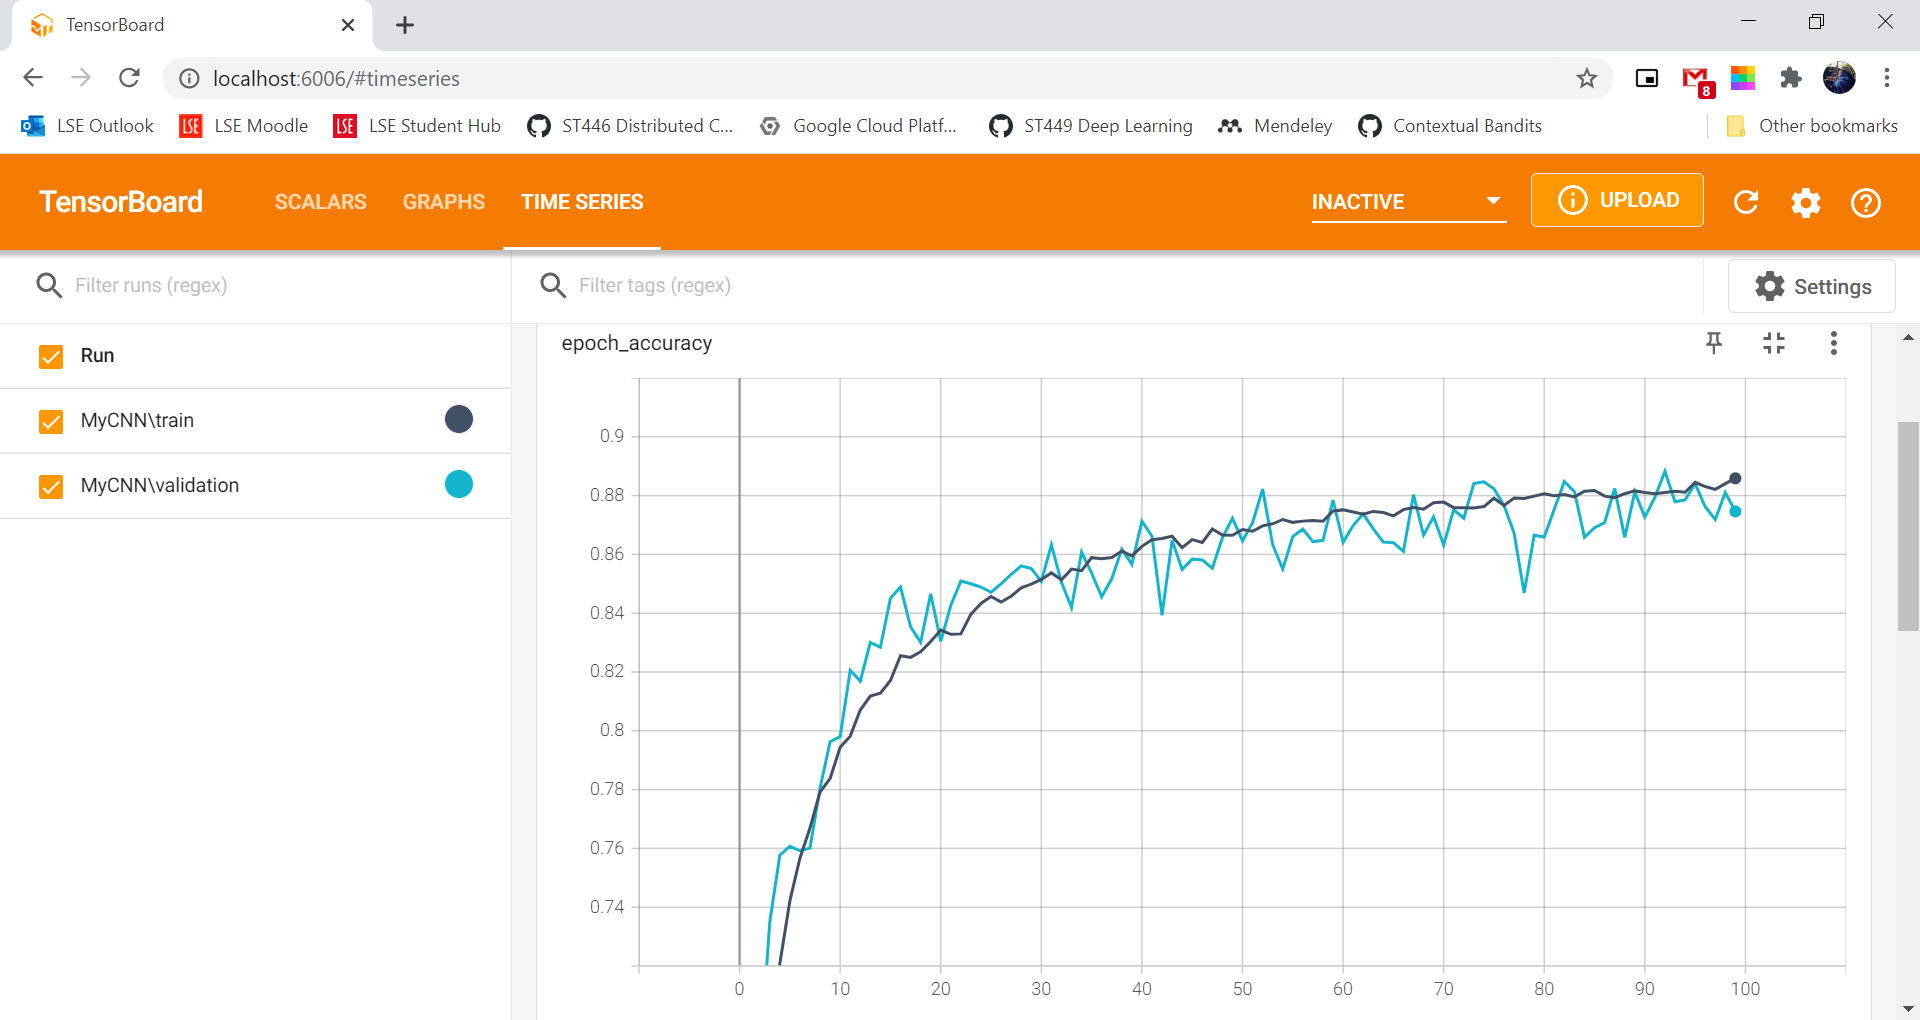

In [6]:
Image(filename='images/p3_accuracy.PNG')

First things first, the model archives prediction (test) accuracy of around 88 percent. It would rank around 100th on the CIFAR10 leaderboard (see Papers with Code [here](https://paperswithcode.com/sota/image-classification-on-cifar-10)), quite far away from the 99+ percent archived by the most stat-of-the-art models (or ensembles). Nevertheless, with its less than 1.2 Mio parameters, it performs roughly as well as the famous DCNN proposed by Alex Krizhevsky, Ilya Sutskever and Geoffrey E. Hinton in 2012 with ~60 Mio parameters (see [here](https://paperswithcode.com/paper/renet-a-recurrent-neural-network-based)). This is a sign of how much progress has been made since then, not only in terms of prediction accuracy, but also in making models more efficient (fewer parameters for the same performance).

#### Loss Curves

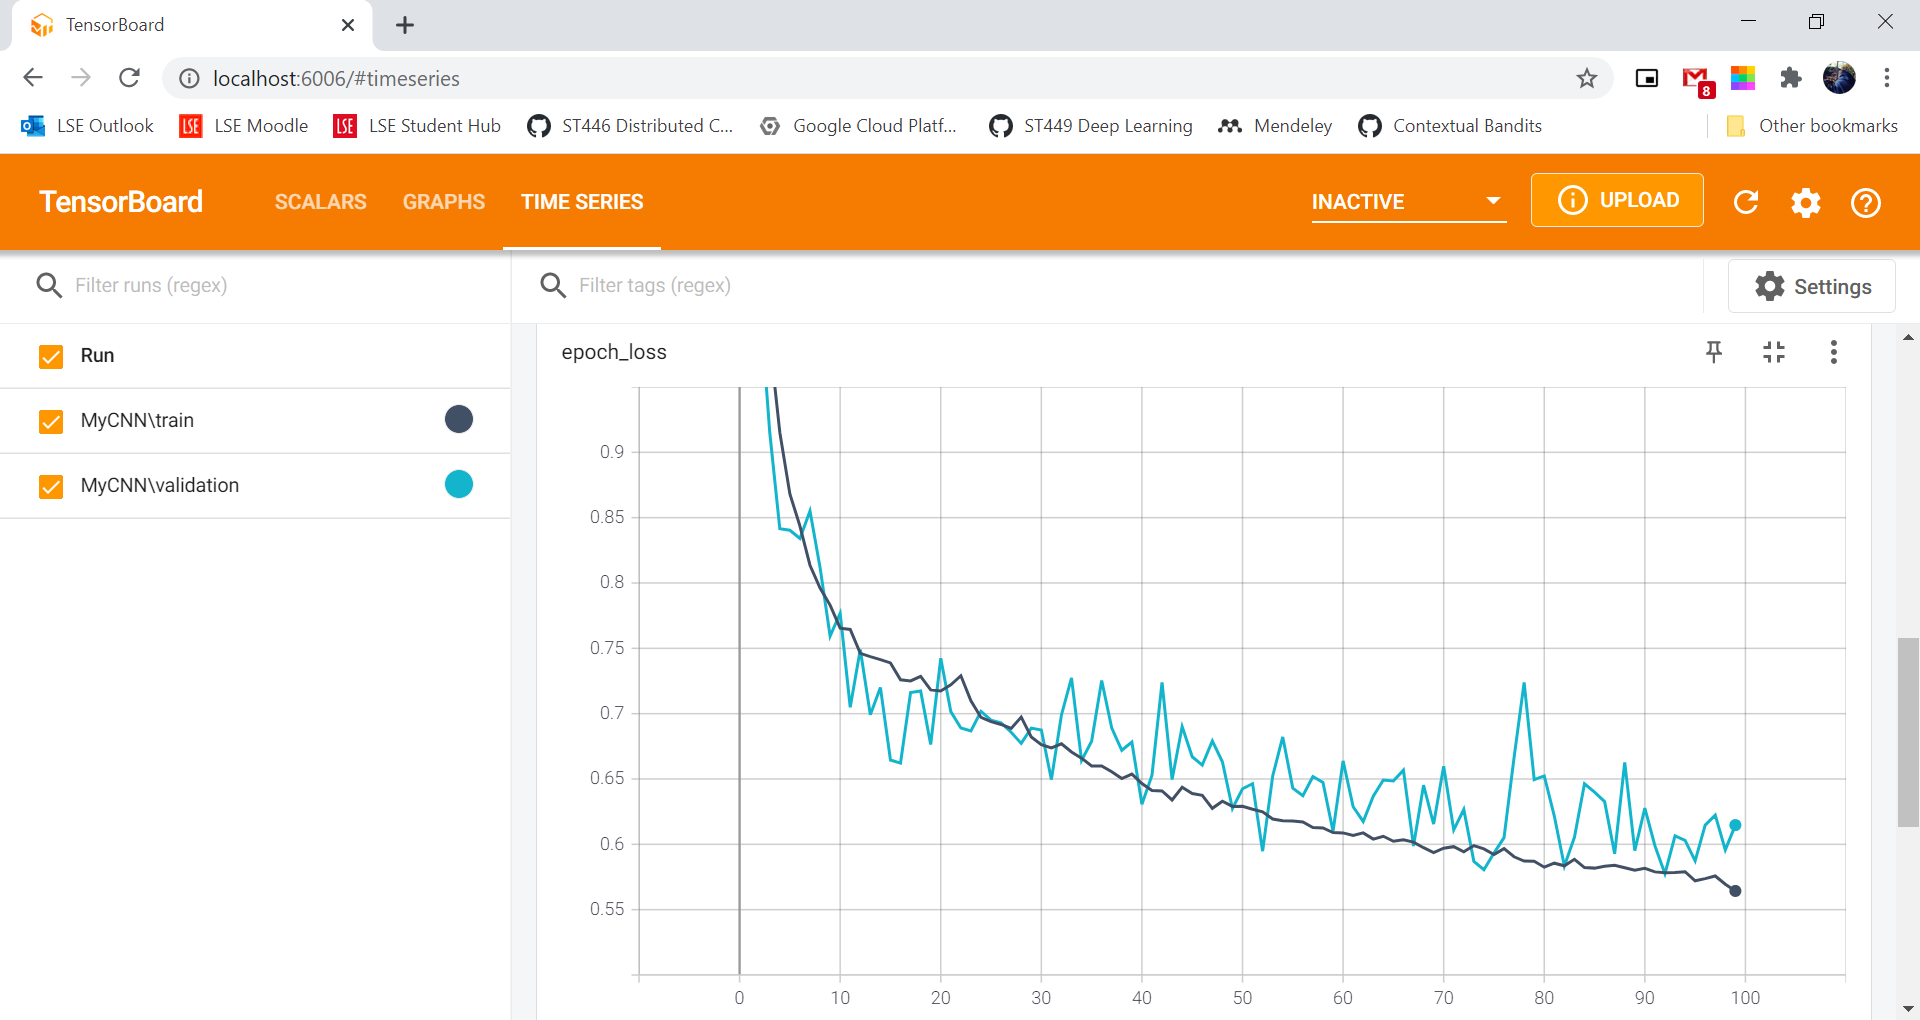

In [7]:
Image(filename='images/p3_loss.PNG') 

In the screenshot above, we can see that the training loss is not strictly decreasing from epoch to epoch. This is not only due to the mini-batch gradient descent but in particular due to the random transformations that are applied to the training data (the random transformations may lead to more difficult images in one epoch as compared to the previous one).

The evaluation loss fluctuates even more strongly, which shows that the model adapts quite strongly to the random image transformations from epoch to epoch. While this sounds like unwanted overfitting, overall the random transformations help the model improve. In addition, the relatively small gap between the training loss and the evaluation loss signals that the model generalizes very well to the unseen test data. A big gap, by contrast, would suggest that the model learns some patterns that are only relevant for the training data but not for the test data. 

What is more, there is no sign of overfitting. The validation loss appears to be still decreasing after 100 epochs. Indeed, the random data augmentations and dropout layers make it more unlikely for the network to overfit, as already mentioned. It may therefore be trained for several more epochs, although with the risk of finally overfitting.

#### Top-5 Accuracy

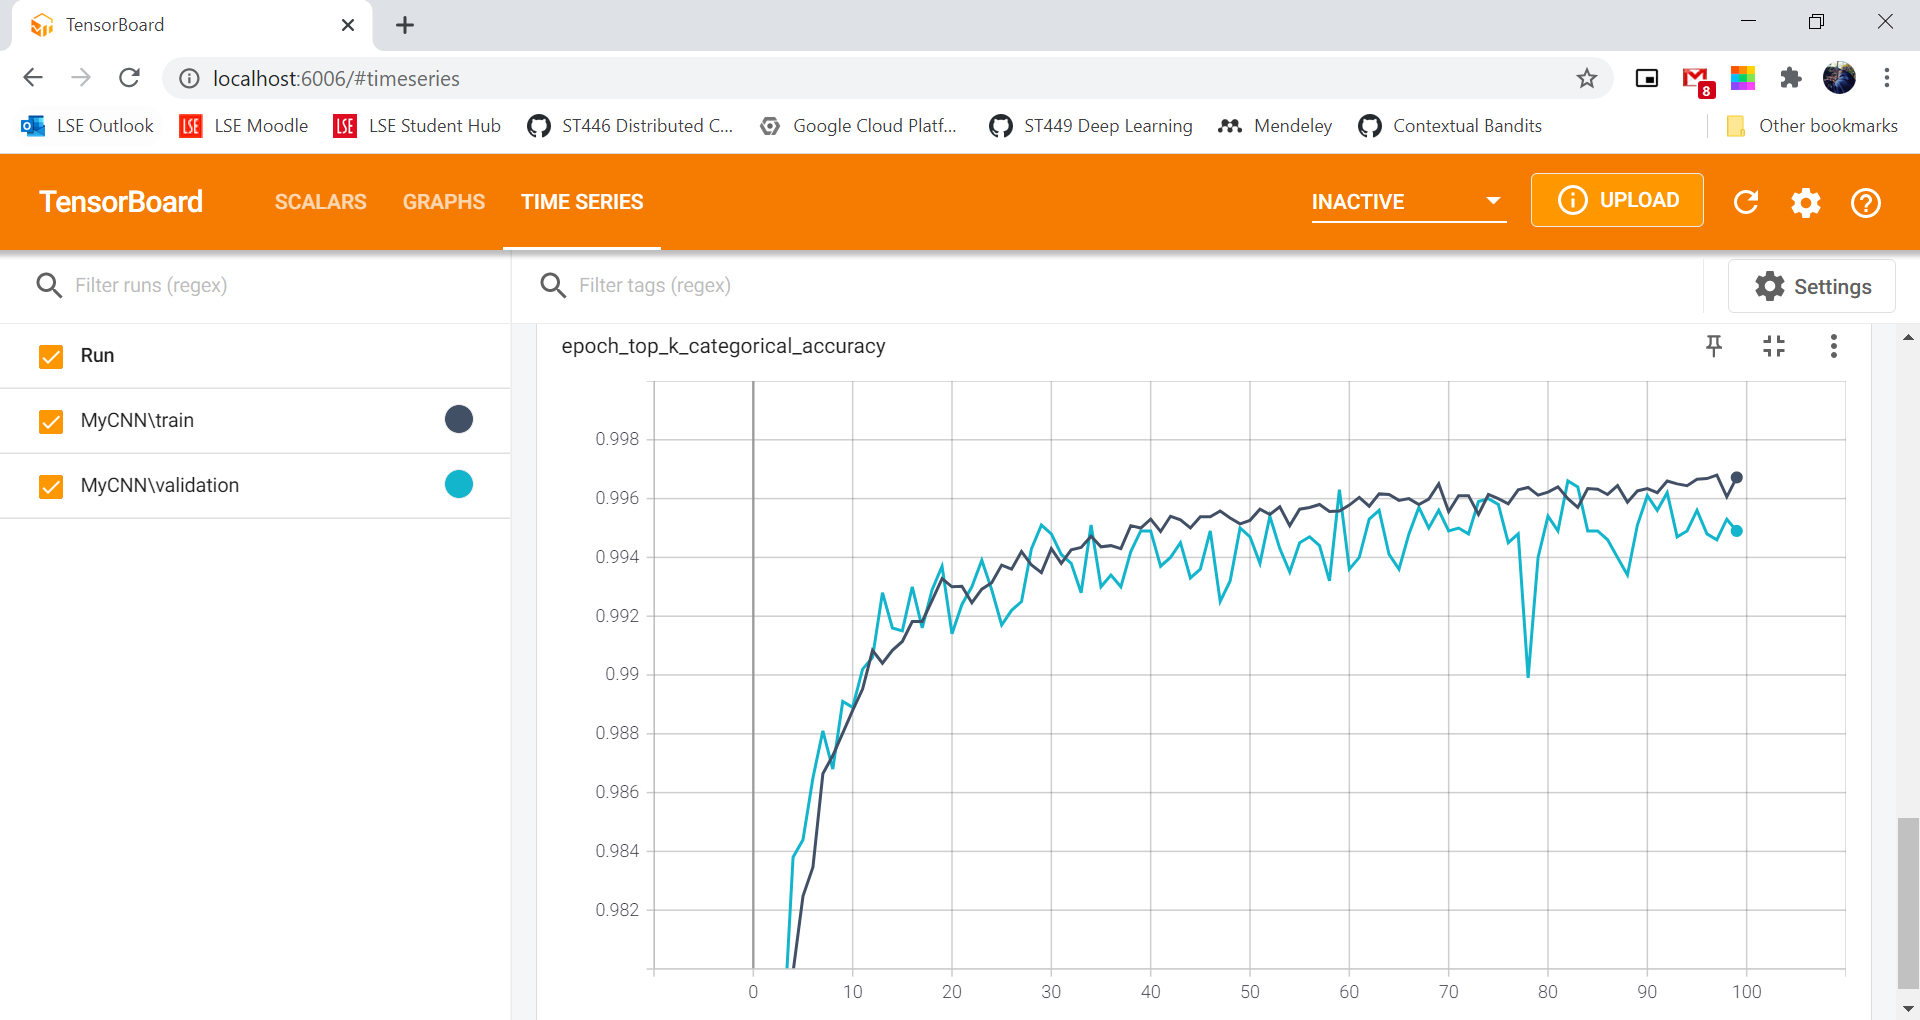

In [8]:
Image(filename='images/p3_topk.PNG') 

The top-5 Accuracy rate reveals little in addition to the previous two plots. It is noteworthy that the model is almost perfect in this sense - most likely outperforming human beings.

Finally, it is also noteworthy to mention that I used a subset of the training data for the hyperparameter tuning but the evaluation curves seen here are generated using the test set. This is to ensure that the test error is accurate and not biased downwards by the tuning process.

#### Transfer Learning
In practice, image recognition models need not always be trained from scratch. Instead, transfer learning can be used. In other words, the weights learned by a CNN trained on a one dataset (say ImageNet) are often also useful for a different dataset. The reason why transfer learning works is that each layer can be seen as a learned feature representation of the original image input. While earlier layers are specialized in detecting small-scale patterns such as vertical or horizontal edges, later layers learn larger patters (such as faces, trees, or tires). These feature representations often generalize to other images (especially the earlier layers). Therefore, a common practice is to use the weights of a pretrained neural network but replace the _head_ of the network (i.e., the last or last few layers) with a custom head that is trained on the task at hand while the other weights are frozen. That way, it is possible to make use of extremely large neural network pretrained by the likes of Google and Facebook, which have the resources to train models with potentially hundreds of millions (even billions) of parameters.

-----------------------   


## Marking scheme

| **Problem breakdown** | **Max marks** | 
|-------------------|---------------|
| P1 correctness of implementation	|	15 |	
| P1 discussion of results	|	15 |
| P2 correctness of implementation    |	15  |
| P2 discussion of results	|	15 |
| P3 network architecture design    |	10 |
| P3 use of different methods   | 10 |
| P3 achieved test error rates    |   10 |
| P3 discussion and presentation of results | 10 |
| | Total 100 |
